In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, re
from google.colab import files

print("원본(202501_clean2.xlsx), 사전 적합도([8.28] Tx-적합도.xlsx) 업로드")
uploaded = files.upload()

원본(202501_clean2.xlsx), 사전 적합도([8.26] Tx-적합도.xlsx) 업로드


Saving [8.28] Tx-적합도.xlsx to [8.28] Tx-적합도.xlsx
Saving 202501_clean2.xlsx to 202501_clean2 (1).xlsx


In [ ]:
RAW_PATH = '202501_clean2.xlsx'
TX_PATH  = '[8.28] Tx-적합도.xlsx'

# 설정값
SELECTION_POLICY = 'composite'

# 복합 점수 가중치
WEIGHTS = {'ks_p': 0.5,   # 높을수록 우수
           'ad':   0.3,   # 낮을수록 우수
           'chi2': 0.2}   # 낮을수록 우수

KS_P_THRESHOLD = 0.05
FALLBACK_DIST  = ('lognorm', '로그 정규')

In [ ]:
# 원본 로딩 및 전처리
df = pd.read_excel(RAW_PATH)
if 'Pump-Begin' in df.columns:
    df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'], errors='coerce')

metal_columns = [c for c in df.columns if '(ng/m3)' in c]
df[metal_columns] = (df[metal_columns]
                     .apply(pd.to_numeric, errors='coerce')
                     .mask(df[metal_columns] < 0))

target_tags = ['Cr','Co','Ni','As','Cd','Sb','Pb']
target_cols = [c for c in metal_columns if any(c.startswith(t+'(') for t in target_tags)]
print(f"[INFO] 대상 금속 컬럼({len(target_cols)}):", target_cols)


[INFO] 대상 금속 컬럼(7): ['Cr(ng/m3)', 'Co(ng/m3)', 'Ni(ng/m3)', 'As(ng/m3)', 'Cd(ng/m3)', 'Sb(ng/m3)', 'Pb(ng/m3)']


In [ ]:
DIST_MAP = {'정규':'norm', '로그 정규':'lognorm', '감마':'gamma', '와이블':'weibull_min',
            '로지스틱':'logistic', '삼각형':'triang', '최대 극값':'gumbel_r', '최소 극값':'gumbel_l',
            '지수':'expon', '균일':'uniform', '베타':'beta', '파레토':'pareto', '스튜던트의 t':'t',
            'BetaPERT':'beta'}

def _sheet_score(df_):
    txt = " ".join([str(x) for x in df_.columns] + df_.astype(str).head(200).stack().tolist())
    score = sum(w in txt for w in ['분포','K-S','P-값','카이제곱'])
    return score

def parse_tx_excel_strong(xlsx_path):
    xls = pd.ExcelFile(xlsx_path)
    best_blocks, best_count, best_sheet = None, 0, None
    for sname in xls.sheet_names:
        raw = pd.read_excel(xlsx_path, sheet_name=sname)
        if _sheet_score(raw) < 5:
            continue
        blocks = {}
        A = raw.fillna("").astype(str)
        # 금속 블록 시작행 탐지
        starts = []
        for i in range(len(A)-1):
            first_val = A.iloc[i, 0].strip()
            next_row_has_header = (A.iloc[i+1, :].eq('분포')).any()
            if first_val not in ("", "데이터 계열") and next_row_has_header:
                starts.append(i)
        # 블록 분할
        for idx, s in enumerate(starts):
            e = starts[idx+1] if idx+1 < len(starts) else len(A)
            metal_name = A.iloc[s, 0].strip()
            header_row = s+1
            table = raw.iloc[header_row:e].copy()
            table.columns = table.iloc[0].tolist()
            table = table.iloc[1:].reset_index(drop=True)
            keep = ['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
            table = table[[c for c in keep if c in table.columns]]
            table = table.dropna(subset=['분포'])
            blocks[metal_name] = table
        if len(blocks) > best_count:
            best_blocks, best_count, best_sheet = blocks, len(blocks), sname
    return best_blocks or {}, best_sheet

tx_blocks, used_sheet = parse_tx_excel_strong(TX_PATH)
print(f"[INFO] 사전 적합도 파싱된 금속 수: {len(tx_blocks)}  (시트: {used_sheet})")
print("[INFO] 파싱 키 일부:", list(tx_blocks.keys())[:10])

[INFO] 사전 적합도 파싱된 금속 수: 0  (시트: None)
[INFO] 파싱 키 일부: []


In [ ]:
# 선택 로직
def _num(s):
    try:
        return pd.to_numeric(s, errors='coerce')
    except Exception:
        return pd.Series([np.nan]*len(s)) if hasattr(s, '__len__') else np.nan

def pick_best_dist_by_composite(table):
    t = table.copy()
    # 대상 컬럼 숫자화
    for col in ['K-S P-값', 'A-D', '카이제곱']:
        if col in t.columns:
            t[col] = _num(t[col])

    # 게이트 : KS P >= threshold 후보군 존재 시 그 안에서 선택
    subset = t[t.get('K-S P-값', pd.Series(dtype=float)) >= KS_P_THRESHOLD]
    cand = subset if len(subset) else t.copy()

    # 순위
    if 'K-S P-값' in cand.columns and cand['K-S P-값'].notna().any():
        r_ks = cand['K-S P-값'].rank(pct=True)
    else:
        r_ks = pd.Series(0.5, index=cand.index)

    if 'A-D' in cand.columns and cand['A-D'].notna().any():
        r_ad = 1.0 - cand['A-D'].rank(ascending=True, pct=True)
    else:
        r_ad = pd.Series(0.5, index=cand.index)

    if '카이제곱' in cand.columns and cand['카이제곱'].notna().any():
        r_chi2 = 1.0 - cand['카이제곱'].rank(ascending=True, pct=True)
    else:
        r_chi2 = pd.Series(0.5, index=cand.index)

    score = (WEIGHTS['ks_p'] * r_ks.fillna(0.5) +
             WEIGHTS['ad']   * r_ad.fillna(0.5) +
             WEIGHTS['chi2'] * r_chi2.fillna(0.5))

    cand = cand.assign(_score=score, _r_ks=r_ks, _r_ad=r_ad, _r_chi2=r_chi2).sort_values('_score', ascending=False)


    cand = cand.sort_values(by=['_score',
                                'K-S P-값' if 'K-S P-값' in cand.columns else '_score',
                                'A-D' if 'A-D' in cand.columns else '_score',
                                '카이제곱' if '카이제곱' in cand.columns else '_score'],
                            ascending=[False, False, True, True])

    chosen_row = cand.iloc[0]
    kor_name = str(chosen_row['분포'])
    return DIST_MAP.get(kor_name, None), kor_name, cand

def pick_best_dist_by_ks_only(table):
    t = table.copy()
    if 'K-S P-값' in t.columns:
        t['K-S P-값'] = _num(t['K-S P-값'])
        good = t[t['K-S P-값'] >= KS_P_THRESHOLD].sort_values('K-S P-값', ascending=False)
        base = good if len(good) else t.sort_values('K-S P-값', ascending=False)
        kor_name = str(base.iloc[0]['분포'])
        return DIST_MAP.get(kor_name, None), kor_name, base
    # KS P-값 자체가 없으면 첫 행
    kor_name = str(t.iloc[0]['분포'])
    return DIST_MAP.get(kor_name, None), kor_name, t

def pick_best_dist(table):
    if SELECTION_POLICY == 'composite':
        return pick_best_dist_by_composite(table)
    else:
        return pick_best_dist_by_ks_only(table)

# 백업 매핑
backup_map = {'Cr' : ('norm','정규'),
              'Co' : ('beta','베타'),
              'Ni' : ('weibull_min','와이블'),
              'Cd' : ('triang','삼각형'),
              'Sb' : ('triang','삼각형'),
              'Pb' : ('expon','지수')}

In [ ]:
# 피팅 유틸 + 플로팅
def _fit_with_guard(dist, data, force_loc0=False):
    try:
        return dist.fit(data, floc=0) if force_loc0 else dist.fit(data)
    except Exception:
        return dist.fit(data)

def fit_distribution(data, dist_name):
    x = np.asarray(data, float)
    x = x[~np.isnan(x)]
    if x.size < 5:
        raise ValueError("표본 수 부족(n<5).")

    positive_only = {'lognorm','gamma','weibull_min','expon','pareto'}
    if dist_name in positive_only:
        x = x[x > 0]
        if x.size < 5:
            raise ValueError("양수 지지 분포: 유효 표본 부족.")

    dist = getattr(stats, dist_name)

    if dist_name == 'beta':
        xmin, xmax = np.nanmin(x), np.nanmax(x)
        if not np.isfinite(xmin) or not np.isfinite(xmax) or xmax-xmin == 0:
            raise ValueError("Beta fit 불가(범위 0).")
        z = (x - xmin) / (xmax - xmin)
        a,b,loc,scale = _fit_with_guard(dist, z, force_loc0=True)
        return (a,b, xmin, xmax-xmin), x  # (a,b,loc,scale) with original scale

    if dist_name == 'triang':
        try:
            c, loc, scale = dist.fit(x)
            return (c, loc, scale), x
        except Exception:
            hist, edges = np.histogram(x, bins='fd')
            xmin, xmax = np.nanmin(x), np.nanmax(x)
            mode = (edges[np.argmax(hist)] + edges[np.argmax(hist)+1]) / 2
            c = (mode - xmin) / (xmax - xmin + 1e-12)
            c = float(np.clip(c, 1e-6, 1-1e-6))
            return (c, xmin, xmax-xmin), x

    force0 = dist_name in {'lognorm','gamma','weibull_min','expon','pareto'}
    params = _fit_with_guard(dist, x, force_loc0=force0)
    return params, x

def ks_pvalue(x, dist_name, params):
    return float(stats.kstest(x, dist_name, args=params)[1])

def format_params(dist_name, params):
    try:
        if dist_name == 'lognorm':
            s, loc, scale = params; return f"s={s:.3g}, loc={loc:.3g}, scale={scale:.3g}"
        if dist_name in {'gamma','weibull_min','t','beta','pareto'}:
            names = ['a','b','loc','scale'][:len(params)]
            return ", ".join(f"{n}={v:.3g}" for n,v in zip(names, params))
        if dist_name in {'gumbel_r','gumbel_l','expon','logistic','norm','uniform'}:
            names = ['loc','scale','arg3','arg4'][:len(params)]
            return ", ".join(f"{n}={v:.3g}" for n,v in zip(names, params))
        if dist_name == 'triang':
            c, loc, scale = params; return f"c={c:.3g}, loc={loc:.3g}, scale={scale:.3g}"
        return str(params)
    except:
        return str(params)

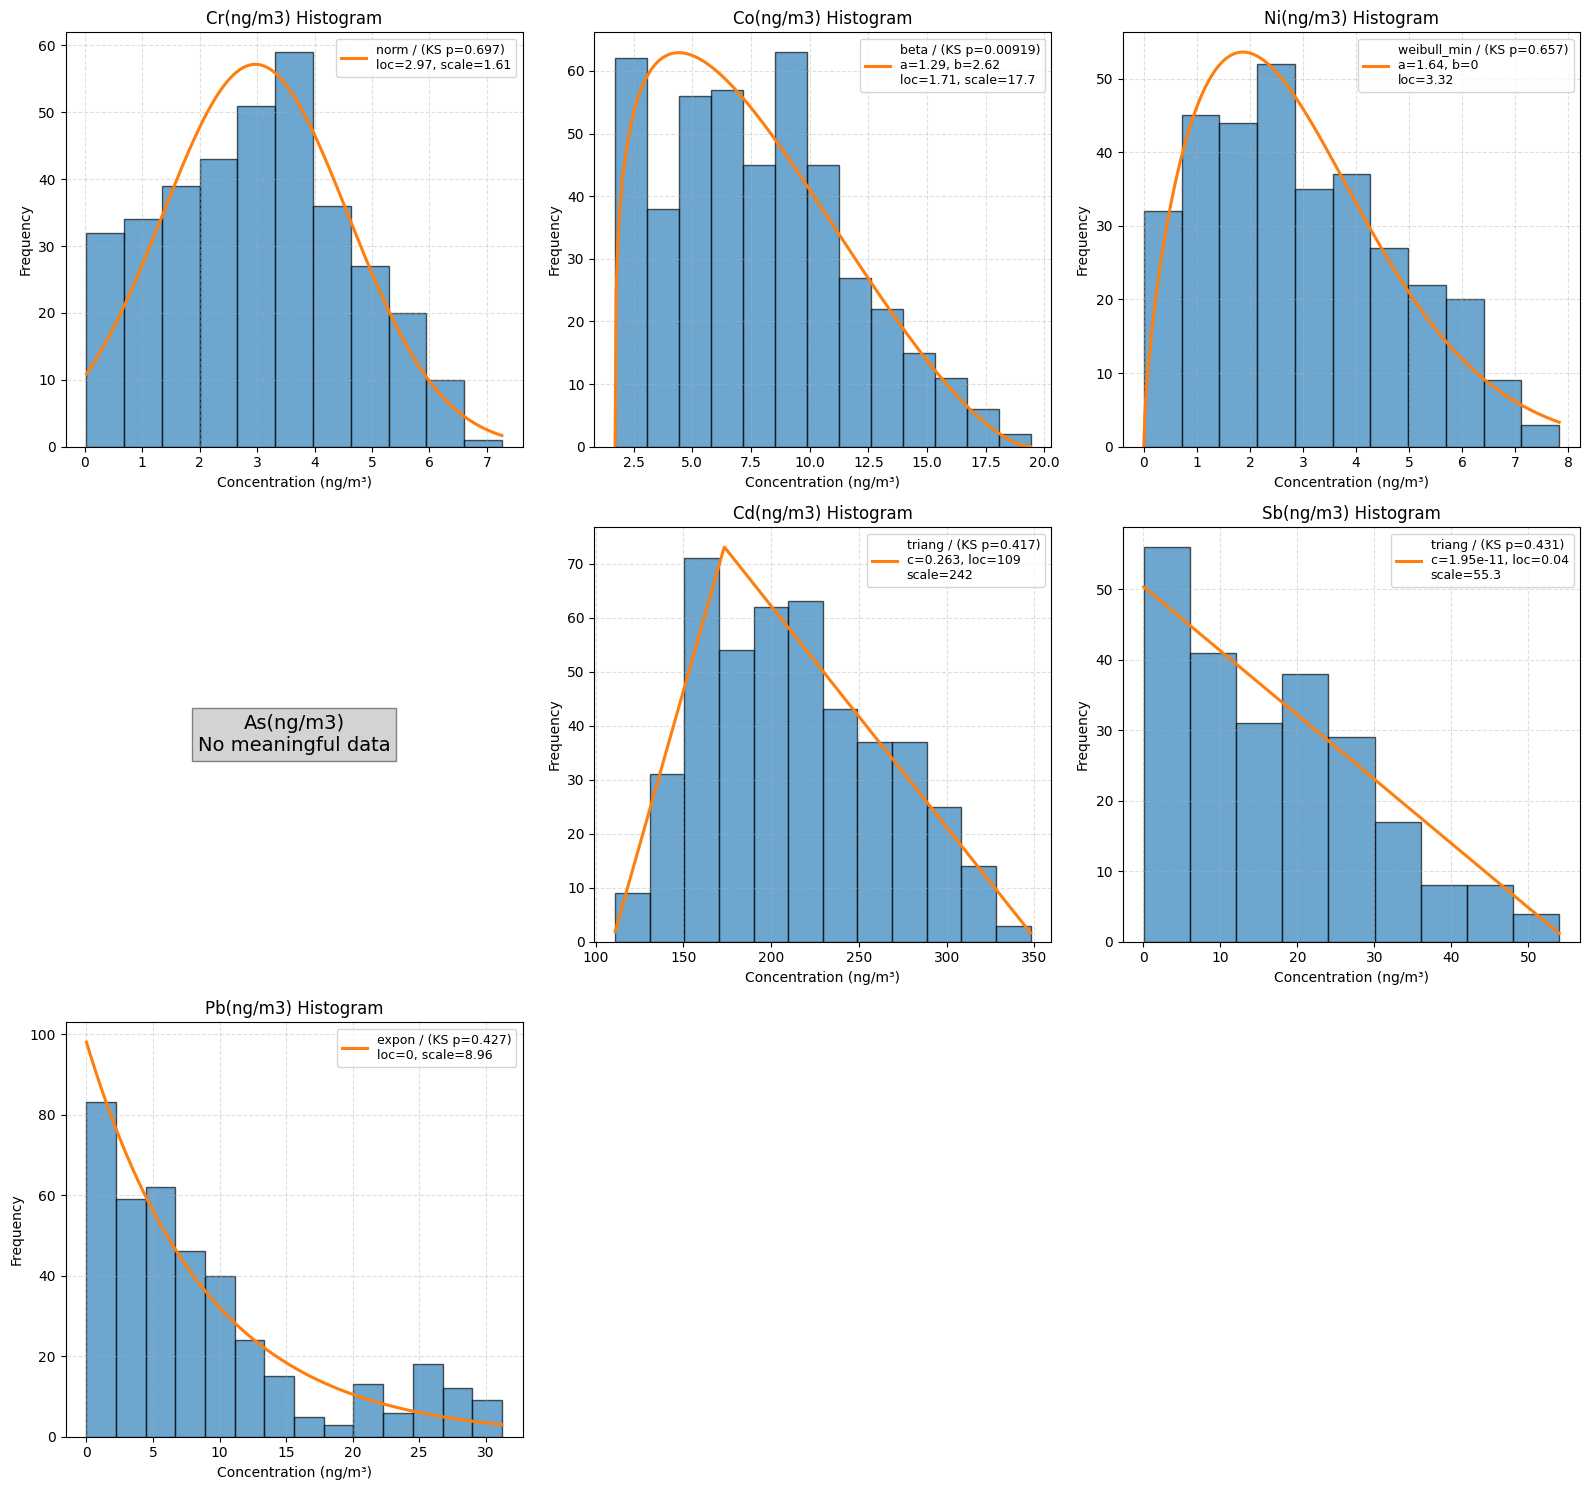

In [ ]:
# 히스토그램 + 단일 분포 피팅
summary_rows = []
diagnostic_rows = []

n = len(target_cols)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5*nrows))
axes = np.ravel(axes) if n > 1 else [axes]

# 파라미터 줄바꿈 (항목 2개씩 줄바꿈)
def wrap_params(text, per_line=2):
    parts = [t.strip() for t in text.split(',') if t.strip()]
    lines = [', '.join(parts[i:i+per_line]) for i in range(0, len(parts), per_line)]
    return '\n'.join(lines)

for i, col in enumerate(target_cols):
    ax = axes[i]
    s = pd.to_numeric(df[col], errors='coerce').dropna()

    if s.nunique() <= 1 or len(s) < 5:
        ax.axis('off')
        ax.text(0.5, 0.5, f"{col}\nNo meaningful data",
                ha='center', va='center', fontsize=14, transform=ax.transAxes,
                bbox=dict(facecolor='lightgray', edgecolor='gray'))
        continue

    # 히스토그램
    counts, bins, _ = ax.hist(s, bins='auto', density=False, edgecolor='black', alpha=0.65)
    ax.set_title(f"{col} Histogram")
    ax.set_xlabel("Concentration (ng/m³)")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.4)

    # 최적 분포 선택
    best = None
    tag = col.split('(')[0].strip()
    key = next((k for k in tx_blocks.keys() if k.strip().lower()==tag.lower()), None)

    chosen_table = None
    if key is not None:
        try:
            scipy_name, kor_name, chosen_table = pick_best_dist(tx_blocks[key])
            if scipy_name:
                best = (scipy_name, kor_name)
        except Exception:
            best = None

    # 파싱 선택 실패 시 백업
    if not best:
        if tag in backup_map:
            best = backup_map[tag]
        else:
            best = FALLBACK_DIST

    best_scipy, best_kor = best

    # 피팅 + 오버레이
    try:
        params, used = fit_distribution(s.values, best_scipy)
        p = ks_pvalue(used, best_scipy, params)

        N = len(used)
        bin_w = float(np.mean(np.diff(bins)))
        xgrid = np.linspace(bins[0], bins[-1], 400)
        dist = getattr(stats, best_scipy)
        pdf = dist.pdf(xgrid, *params) * N * bin_w  # 빈도 스케일

        # 라벨 생성: 전 금속 동일 규칙(파라미터 줄바꿈)
        param_text = format_params(best_scipy, params)   # 저장용 원본
        param_text_wrapped = wrap_params(param_text, per_line=2)
        label = f"{best_scipy} / (KS p={p:.3g})\n{param_text_wrapped}"

        ax.plot(xgrid, pdf, lw=2.2, label=label)
        ax.legend(fontsize=9, loc='upper right', frameon=True)

        summary_rows.append({'Metal': col,
                             'ChosenDist(KOR)': best_kor,
                             'ChosenDist(SciPy)': best_scipy,
                             'KS_p (fit)': p,
                             'Params': param_text,          # 저장은 줄바꿈 없는 원본으로
                             'N_used': N,
                             'bin_width_mean': bin_w,
                             'Policy': SELECTION_POLICY,
                             'TX_Sheet': used_sheet})

        # 선택 근거 저장
        if isinstance(chosen_table, pd.DataFrame) and '_score' in chosen_table.columns:
            ct = chosen_table.copy()
            ct['Metal'] = col
            diagnostic_rows.append(ct[['Metal','분포','K-S P-값','A-D','카이제곱','_r_ks','_r_ad','_r_chi2','_score']].reset_index(drop=True))

    except Exception as e:
        ax.text(0.5, 0.15, f"fit_error: {e}", ha='center', transform=ax.transAxes,
                bbox=dict(facecolor='mistyrose', edgecolor='red'))
        summary_rows.append({'Metal': col,
                             'ChosenDist(KOR)': best_kor,
                             'ChosenDist(SciPy)': best_scipy,
                             'KS_p (fit)': np.nan,
                             'Params': f'fit_error: {e}',
                             'N_used': len(s),
                             'bin_width_mean': np.nan,
                             'Policy': SELECTION_POLICY,
                             'TX_Sheet': used_sheet})

# 남는 축 숨기기
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# 부적합 3개 금속 다시 피팅

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os, math, warnings
warnings.filterwarnings("ignore")

# 원본 데이터 로드
RAW_PATH = "202501_clean2.xlsx"
df = pd.read_excel(RAW_PATH)

In [45]:
#분석할 금속 (불일치 대상으로 지정)
target_cols = ["Co(ng/m3)", "Ni(ng/m3)", "Cd(ng/m3)"]

# 후보 14개 분포 (BetaPERT 제외)
DIST_LIST = {
    "정규":"norm", "스튜던트t":"t", "삼각형":"triang", "로지스틱":"logistic",
    "베타":"beta", "최대극값":"gumbel_r", "최소극값":"gumbel_l",
    "와이블":"weibull_min", "감마":"gamma", "로그정규":"lognorm",
    "지수":"expon", "균일":"uniform", "파레토":"pareto"
}

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        nshape = d.numargs
    except:
        nshape = len(params)-2
    return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

def eval_dist(x, name, scipy_name):
    out = {"분포":name}
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        n = len(x)
        aic = 2*k - 2*ll
        bic = math.log(n)*k - 2*ll
        D,p = stats.kstest(x, scipy_name, args=params)
        out.update({"status":"ok","params":params,"KS_p":p,"AIC":aic,"BIC":bic})
    except Exception as e:
        out.update({"status":f"fail {e}","params":None,"KS_p":np.nan,"AIC":np.inf,"BIC":np.inf})
    return out

def analyze_metal(series, metal_name, outdir="fit_results"):
    x = pd.to_numeric(series, errors="coerce").dropna().values
    rows=[]
    for name,scipy_name in DIST_LIST.items():
        rows.append(eval_dist(x, name, scipy_name))
    rows_ok=[r for r in rows if r["status"]=="ok"]

    # 정렬
    rows_sorted = sorted(rows_ok, key=lambda r:(-r["KS_p"], r["AIC"], r["BIC"]))
    top3 = rows_sorted[:3]

    # 히스토그램 + Top-3 오버레이
    counts, bins, _ = plt.hist(x, bins="auto", density=False, edgecolor="black", alpha=0.65)
    bin_w = np.mean(np.diff(bins)); N=len(x); xgrid=np.linspace(bins[0], bins[-1],500)

    for r in top3:
        d = getattr(stats, DIST_LIST[r["분포"]])
        pdf = d.pdf(xgrid, *r["params"])
        label = f"{r['분포']} | KS p={r['KS_p']:.3f}, AIC={r['AIC']:.1f}"
        plt.plot(xgrid, pdf*N*bin_w, lw=2, label=label)

    plt.title(f"{metal_name} Top-3 Fits")
    plt.xlabel("Concentration (ng/m³)")
    plt.ylabel("Frequency")
    plt.legend(fontsize=8)
    plt.grid(True, linestyle="--", alpha=0.4)
    os.makedirs(outdir, exist_ok=True)

    # 특수문자 제거한 안전한 파일명
    import re
    safe_name = re.sub(r'[^a-zA-Z0-9가-힣_-]', '_', metal_name)
    fpath = os.path.join(outdir, f"{safe_name}_top3.png")

    plt.tight_layout(); plt.savefig(fpath, dpi=150); plt.close()

    # 최종 선정
    ks_ok=[r for r in top3 if r["KS_p"]>=0.05]
    if ks_ok:
        best=min(ks_ok, key=lambda r:r["AIC"])
    else:
        best=max(top3, key=lambda r:r["KS_p"])
    return rows_sorted, top3, best, fpath

# 실행
summary=[]
for col in target_cols:
    rows,top3,best,fpath=analyze_metal(df[col], col)
    print(f"[{col}] 최종선정: {best['분포']} (KS p={best['KS_p']:.3f}, AIC={best['AIC']:.1f}) → {fpath}")
    summary.append({"Metal":col,"Best":best["분포"],"KS_p":best["KS_p"],"AIC":best["AIC"],"BIC":best["BIC"]})

pd.DataFrame(summary)

[Co(ng/m3)] 최종선정: 베타 (KS p=0.144, AIC=2414.3) → fit_results/Co_ng_m3__top3.png
[Ni(ng/m3)] 최종선정: 베타 (KS p=0.859, AIC=1260.1) → fit_results/Ni_ng_m3__top3.png
[Cd(ng/m3)] 최종선정: 삼각형 (KS p=0.417, AIC=4760.1) → fit_results/Cd_ng_m3__top3.png


,Metal,Best,KS_p,AIC,BIC
0,Co(ng/m3),베타,0.144470,2414.270687,2430.698779
1,Ni(ng/m3),베타,0.858792,1260.143930,1275.291519
2,Cd(ng/m3),삼각형,0.416584,4760.094376,4772.415445


In [46]:
top3_list = []
for col in target_cols:
    rows, top3, best, fpath = analyze_metal(df[col], col)
    for rank, r in enumerate(top3, start=1):
        top3_list.append({
            "Metal": col,
            "Rank": rank,
            "Dist": r["분포"],
            "KS_p": r["KS_p"],
            "AIC": r["AIC"],
            "BIC": r["BIC"]
        })

df_top3 = pd.DataFrame(top3_list)
display(df_top3)

,Metal,Rank,Dist,KS_p,AIC,BIC
0,Co(ng/m3),1,베타,0.144470,2414.270687,2430.698779
1,Co(ng/m3),2,삼각형,0.112168,2416.277764,2428.598833
2,Co(ng/m3),3,스튜던트t,0.068872,2499.142755,2511.463823
3,Ni(ng/m3),1,베타,0.858792,1260.143930,1275.291519
4,Ni(ng/m3),2,와이블,0.693333,1272.826210,1284.186902
5,Ni(ng/m3),3,삼각형,0.629841,1263.122458,1274.483150
6,Cd(ng/m3),1,베타,0.669024,4763.474205,4779.902297
7,Cd(ng/m3),2,와이블,0.422489,4772.737015,4785.058084
8,Cd(ng/m3),3,삼각형,0.416584,4760.094376,4772.415445


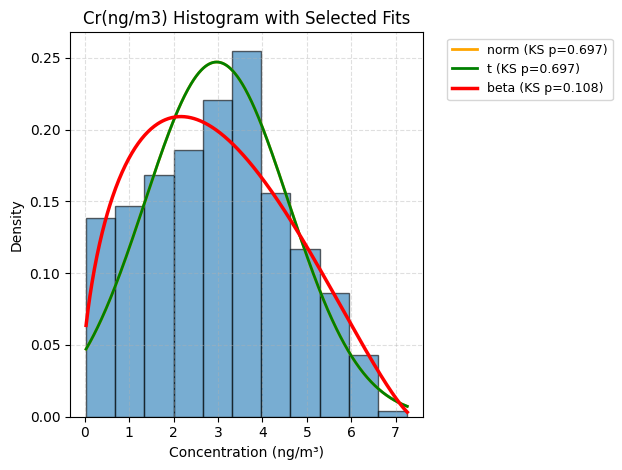

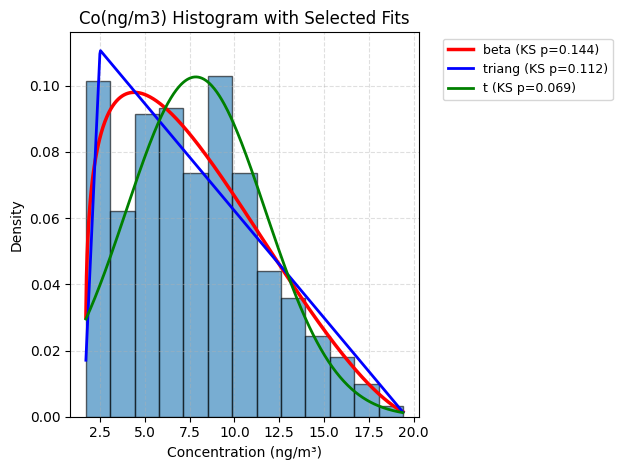

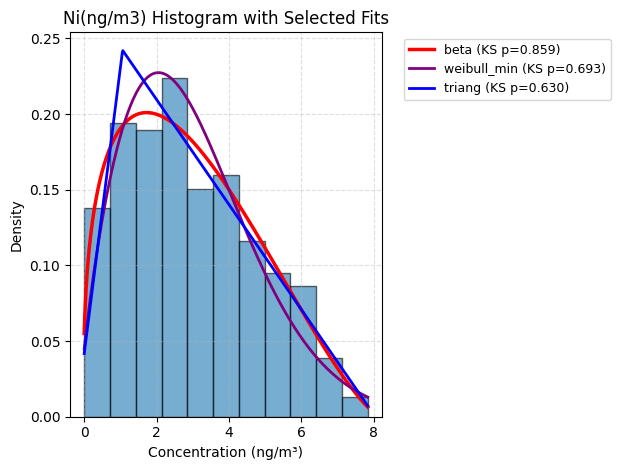

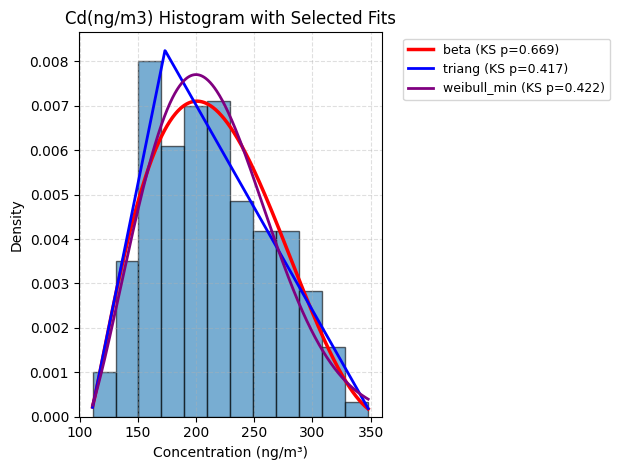

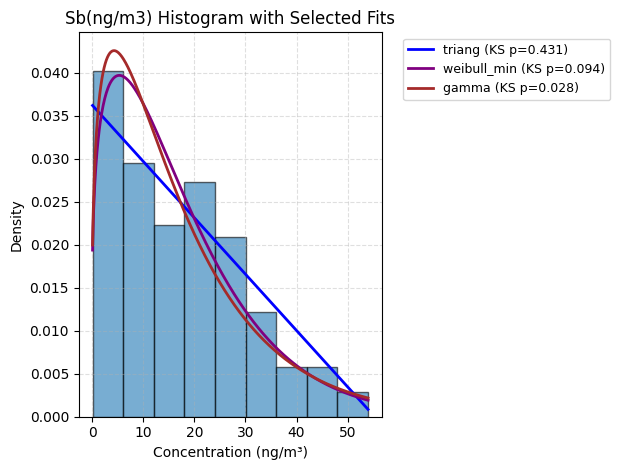

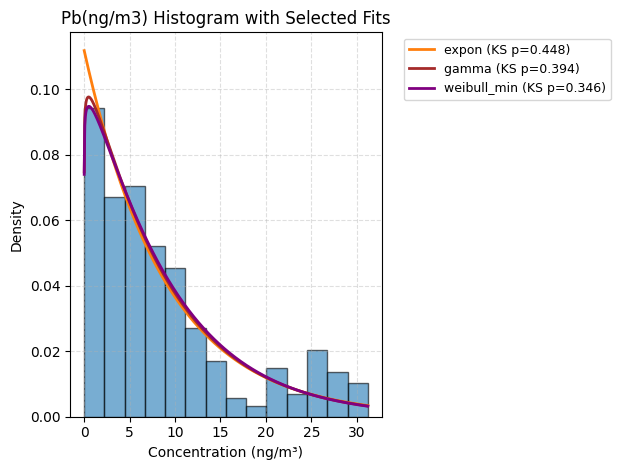

,Metal,dist,KS_p,AIC,BIC
0,Cr(ng/m3),norm,0.697034,1340.221257,1347.948519
1,Cr(ng/m3),t,0.697034,1342.221257,1353.812150
2,Cr(ng/m3),beta,0.107965,1316.851111,1332.305636
3,Co(ng/m3),beta,0.144470,2414.270687,2430.698779
4,Co(ng/m3),triang,0.112168,2416.277764,2428.598833
5,Co(ng/m3),t,0.068872,2499.142755,2511.463823
6,Ni(ng/m3),beta,0.858792,1260.143930,1275.291519
7,Ni(ng/m3),weibull_min,0.693333,1272.826210,1284.186902
8,Ni(ng/m3),triang,0.629841,1263.122458,1274.483150
9,Cd(ng/m3),beta,0.669024,4763.474205,4779.902297


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings, math
warnings.filterwarnings("ignore")

# 분포별 스타일 매핑
STYLE_MAP = {
    "norm": {"color": "orange", "linestyle": "-", "lw": 2},
    "t": {"color": "green", "linestyle": "-", "lw": 2},
    "beta": {"color": "red", "linestyle": "-", "lw": 2.5},
    "triang": {"color": "blue", "linestyle": "-", "lw": 2},
    "weibull_min": {"color": "purple", "linestyle": "-", "lw": 2},
    "gamma": {"color": "brown", "linestyle": "-", "lw": 2},}

# 금속별 후보 분포 딕셔너리
DIST_MAP = {
    "Cr(ng/m3)": ["norm", "t", "beta"],
    "Co(ng/m3)": ["beta", "triang", "t"],
    "Ni(ng/m3)": ["beta", "weibull_min", "triang"],
    "Cd(ng/m3)": ["beta", "triang", "weibull_min"],
    "Sb(ng/m3)": ["triang", "weibull_min", "gamma"],
    "Pb(ng/m3)": ["expon", "gamma", "weibull_min"]
}

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

all_results = []

# 금속별 루프
for col, dist_list in DIST_MAP.items():
    x = pd.to_numeric(df[col], errors="coerce").dropna().values
    if len(x) < 5:
        print(f"[경고] {col}: 데이터 부족 (n={len(x)})")
        continue

    results = []
    counts, bins, _ = plt.hist(x, bins="auto", density=True, edgecolor="black", alpha=0.6)
    N = len(x)
    xgrid = np.linspace(bins[0], bins[-1], 500)

    for scipy_name in dist_list:
        try:
            d = getattr(stats, scipy_name)
            params = d.fit(x)

            # KS 검정
            D, pks = stats.kstest(x, scipy_name, args=params)

            # AIC/BIC
            ll = loglikelihood(scipy_name, params, x)
            k = count_params(scipy_name, params)
            aic = 2*k - 2*ll
            bic = math.log(N)*k - 2*ll

            # PDF 오버레이
            pdf = d.pdf(xgrid, *params)
            style = STYLE_MAP.get(scipy_name, {"lw": 2})
            plt.plot(
                xgrid, pdf,
                label=f"{scipy_name} (KS p={pks:.3f})",
                **style, zorder=5)

            results.append({
                "Metal": col,
                "dist": scipy_name,
                "KS_p": pks,
                "AIC": aic,
                "BIC": bic
            })
        except Exception as e:
            results.append({
                "Metal": col,
                "dist": scipy_name,
                "KS_p": np.nan,
                "AIC": np.nan,
                "BIC": np.nan,
                "error": str(e)
            })

    # 그래프
    plt.title(f"{col} Histogram with Selected Fits")
    plt.xlabel("Concentration (ng/m³)")
    plt.ylabel("Density")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    all_results.extend(results)

# 전체 결과 테이블
df_res = pd.DataFrame(all_results)
display(df_res[["Metal","dist","KS_p","AIC","BIC"]])

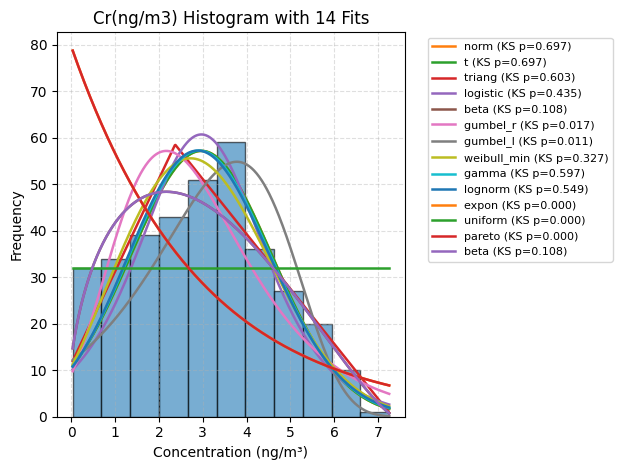

,dist,KS_p,AIC,BIC
0,norm,6.970342e-01,1340.221257,1347.948519
1,t,6.970336e-01,1342.221257,1353.812150
2,triang,6.025455e-01,1329.248518,1340.839412
8,gamma,5.967882e-01,1341.891325,1353.482219
9,lognorm,5.493225e-01,1341.867782,1353.458676
3,logistic,4.348554e-01,1360.536934,1368.264196
7,weibull_min,3.265091e-01,1330.072598,1341.663492
4,beta,1.079647e-01,1316.851111,1332.305636
13,beta,1.079647e-01,1316.851111,1332.305636
5,gumbel_r,1.690479e-02,1367.491013,1375.218275


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, warnings
warnings.filterwarnings("ignore")

# Cr 데이터 불러오기
x = pd.to_numeric(df["Cr(ng/m3)"], errors="coerce").dropna().values

# 후보 14개 분포 (scipy 이름 그대로 사용 → 영어 표시)
DIST_LIST = [
    "norm","t","triang","logistic","beta",
    "gumbel_r","gumbel_l","weibull_min","gamma","lognorm",
    "expon","uniform","pareto","beta"  # BetaPERT 근사로 beta 재사용
]

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

results = []

# 히스토그램 기본
counts, bins, _ = plt.hist(x, bins="auto", density=False, edgecolor="black", alpha=0.6)
bin_w = np.mean(np.diff(bins)); N=len(x)
xgrid = np.linspace(bins[0], bins[-1], 500)

# 분포별 피팅 + PDF 곡선
for scipy_name in DIST_LIST:
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        # KS 검정
        D, pks = stats.kstest(x, scipy_name, args=params)
        # AIC/BIC
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        aic = 2*k - 2*ll
        bic = math.log(N)*k - 2*ll
        # PDF 곡선
        pdf = d.pdf(xgrid, *params)
        plt.plot(xgrid, pdf*N*bin_w, lw=1.8, label=f"{scipy_name} (KS p={pks:.3f})")

        results.append({
            "dist": scipy_name, "params": params, "KS_p": pks,
            "AIC": aic, "BIC": bic
        })
    except Exception as e:
        results.append({"dist": scipy_name, "error": str(e)})

# 그래프 설정
plt.title("Cr(ng/m3) Histogram with 14 Fits")
plt.xlabel("Concentration (ng/m³)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.4)

# 범례를 그래프 바깥 오른쪽에 표시
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 결과표 정리
df_res = pd.DataFrame(results)
df_res = df_res.dropna(subset=["KS_p"]).sort_values("KS_p", ascending=False)
display(df_res[["dist","KS_p","AIC","BIC"]])

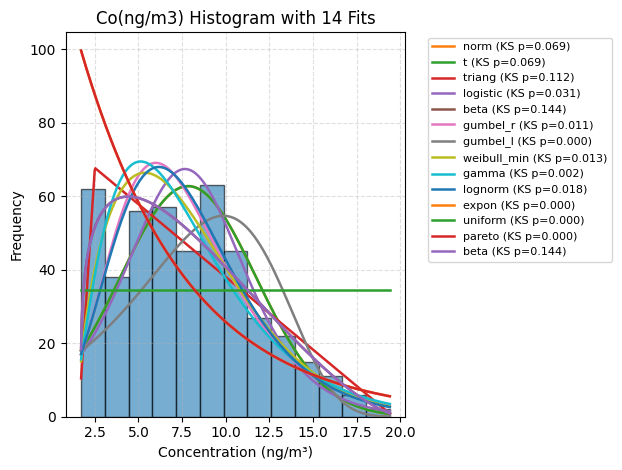

,dist,KS_p,AIC,BIC
4,beta,1.444704e-01,2414.270687,2430.698779
13,beta,1.444704e-01,2414.270687,2430.698779
2,triang,1.121682e-01,2416.277764,2428.598833
1,t,6.887217e-02,2499.142755,2511.463823
0,norm,6.886307e-02,2497.142755,2505.356800
3,logistic,3.091971e-02,2516.012211,2524.226257
9,lognorm,1.815013e-02,2469.665657,2481.986725
7,weibull_min,1.271846e-02,2435.289245,2447.610314
5,gumbel_r,1.128466e-02,2473.441194,2481.655240
8,gamma,1.834673e-03,2456.445131,2468.766199


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, warnings
warnings.filterwarnings("ignore")

# Co 데이터 불러오기
x = pd.to_numeric(df["Co(ng/m3)"], errors="coerce").dropna().values

# 후보 14개 분포 (scipy 이름 그대로 사용 → 영어 표시)
DIST_LIST = [
    "norm","t","triang","logistic","beta",
    "gumbel_r","gumbel_l","weibull_min","gamma","lognorm",
    "expon","uniform","pareto","beta"  # BetaPERT 근사로 beta 재사용
]

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

results = []

# 히스토그램 기본
counts, bins, _ = plt.hist(x, bins="auto", density=False, edgecolor="black", alpha=0.6)
bin_w = np.mean(np.diff(bins)); N=len(x)
xgrid = np.linspace(bins[0], bins[-1], 500)

# 분포별 피팅 + PDF 곡선
for scipy_name in DIST_LIST:
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        # KS 검정
        D, pks = stats.kstest(x, scipy_name, args=params)
        # AIC/BIC
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        aic = 2*k - 2*ll
        bic = math.log(N)*k - 2*ll
        # PDF 곡선
        pdf = d.pdf(xgrid, *params)
        plt.plot(xgrid, pdf*N*bin_w, lw=1.8, label=f"{scipy_name} (KS p={pks:.3f})")

        results.append({
            "dist": scipy_name, "params": params, "KS_p": pks,
            "AIC": aic, "BIC": bic
        })
    except Exception as e:
        results.append({"dist": scipy_name, "error": str(e)})

# 그래프 설정
plt.title("Co(ng/m3) Histogram with 14 Fits")
plt.xlabel("Concentration (ng/m³)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.4)

# 범례를 그래프 바깥 오른쪽에 표시
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 결과표 정리
df_res = pd.DataFrame(results)
df_res = df_res.dropna(subset=["KS_p"]).sort_values("KS_p", ascending=False)
display(df_res[["dist","KS_p","AIC","BIC"]])

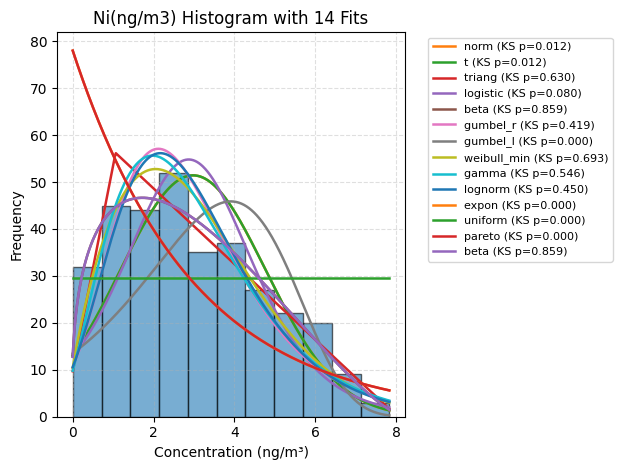

,dist,KS_p,AIC,BIC
4,beta,8.587917e-01,1260.143930,1275.291519
13,beta,8.587917e-01,1260.143930,1275.291519
7,weibull_min,6.933329e-01,1272.826210,1284.186902
2,triang,6.298405e-01,1263.122458,1274.483150
8,gamma,5.461052e-01,1283.939773,1295.300465
9,lognorm,4.502903e-01,1290.567153,1301.927845
5,gumbel_r,4.185824e-01,1291.859038,1299.432833
3,logistic,8.043338e-02,1329.742745,1337.316539
1,t,1.234907e-02,1314.369503,1325.730195
0,norm,1.234785e-02,1312.369503,1319.943298


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, warnings
warnings.filterwarnings("ignore")

# Ni 데이터 불러오기
x = pd.to_numeric(df["Ni(ng/m3)"], errors="coerce").dropna().values

# 후보 14개 분포 (scipy 이름 그대로 사용 → 영어 표시)
DIST_LIST = [
    "norm","t","triang","logistic","beta",
    "gumbel_r","gumbel_l","weibull_min","gamma","lognorm",
    "expon","uniform","pareto","beta"  # BetaPERT 근사로 beta 재사용
]

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

results = []

# 히스토그램 기본
counts, bins, _ = plt.hist(x, bins="auto", density=False, edgecolor="black", alpha=0.6)
bin_w = np.mean(np.diff(bins)); N=len(x)
xgrid = np.linspace(bins[0], bins[-1], 500)

# 분포별 피팅 + PDF 곡선
for scipy_name in DIST_LIST:
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        # KS 검정
        D, pks = stats.kstest(x, scipy_name, args=params)
        # AIC/BIC
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        aic = 2*k - 2*ll
        bic = math.log(N)*k - 2*ll
        # PDF 곡선
        pdf = d.pdf(xgrid, *params)
        plt.plot(xgrid, pdf*N*bin_w, lw=1.8, label=f"{scipy_name} (KS p={pks:.3f})")

        results.append({
            "dist": scipy_name, "params": params, "KS_p": pks,
            "AIC": aic, "BIC": bic
        })
    except Exception as e:
        results.append({"dist": scipy_name, "error": str(e)})

# 그래프 설정
plt.title("Ni(ng/m3) Histogram with 14 Fits")
plt.xlabel("Concentration (ng/m³)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.4)

# 범례를 그래프 바깥 오른쪽에 표시
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 결과표 정리
df_res = pd.DataFrame(results)
df_res = df_res.dropna(subset=["KS_p"]).sort_values("KS_p", ascending=False)
display(df_res[["dist","KS_p","AIC","BIC"]])

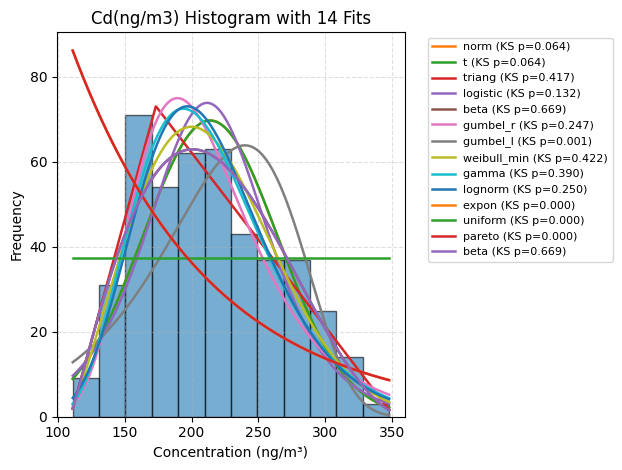

,dist,KS_p,AIC,BIC
4,beta,6.690238e-01,4763.474205,4779.902297
13,beta,6.690238e-01,4763.474205,4779.902297
7,weibull_min,4.224887e-01,4772.737015,4785.058084
2,triang,4.165838e-01,4760.094376,4772.415445
8,gamma,3.901692e-01,4783.233458,4795.554527
9,lognorm,2.500915e-01,4787.680691,4800.001759
5,gumbel_r,2.468841e-01,4793.779259,4801.993304
3,logistic,1.324581e-01,4830.295315,4838.509360
0,norm,6.448466e-02,4803.403052,4811.617098
1,t,6.425776e-02,4805.421993,4817.743062


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, warnings
warnings.filterwarnings("ignore")

# Cd 데이터 불러오기
x = pd.to_numeric(df["Cd(ng/m3)"], errors="coerce").dropna().values

# 후보 14개 분포 (scipy 이름 그대로 사용 → 영어 표시)
DIST_LIST = [
    "norm","t","triang","logistic","beta",
    "gumbel_r","gumbel_l","weibull_min","gamma","lognorm",
    "expon","uniform","pareto","beta"  # BetaPERT 근사로 beta 재사용
]

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

results = []

# 히스토그램 기본
counts, bins, _ = plt.hist(x, bins="auto", density=False, edgecolor="black", alpha=0.6)
bin_w = np.mean(np.diff(bins)); N=len(x)
xgrid = np.linspace(bins[0], bins[-1], 500)

# 분포별 피팅 + PDF 곡선
for scipy_name in DIST_LIST:
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        # KS 검정
        D, pks = stats.kstest(x, scipy_name, args=params)
        # AIC/BIC
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        aic = 2*k - 2*ll
        bic = math.log(N)*k - 2*ll
        # PDF 곡선
        pdf = d.pdf(xgrid, *params)
        plt.plot(xgrid, pdf*N*bin_w, lw=1.8, label=f"{scipy_name} (KS p={pks:.3f})")

        results.append({
            "dist": scipy_name, "params": params, "KS_p": pks,
            "AIC": aic, "BIC": bic
        })
    except Exception as e:
        results.append({"dist": scipy_name, "error": str(e)})

# 그래프 설정
plt.title("Cd(ng/m3) Histogram with 14 Fits")
plt.xlabel("Concentration (ng/m³)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.4)

# 범례를 그래프 바깥 오른쪽에 표시
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 결과표 정리
df_res = pd.DataFrame(results)
df_res = df_res.dropna(subset=["KS_p"]).sort_values("KS_p", ascending=False)
display(df_res[["dist","KS_p","AIC","BIC"]])

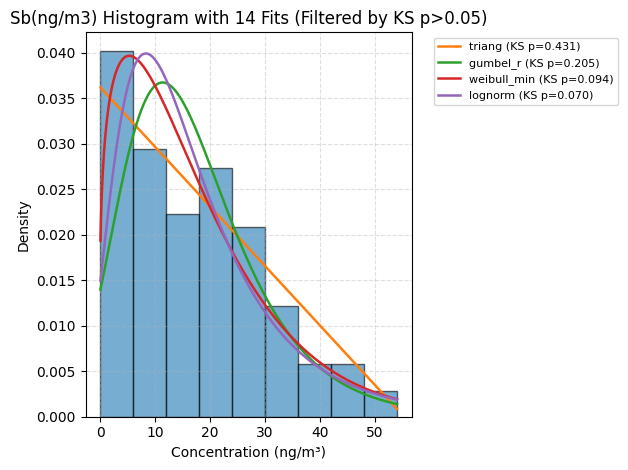

,dist,KS_p,AIC,BIC
2,triang,4.309809e-01,1761.209581,1771.549793
5,gumbel_r,2.050307e-01,1811.521311,1818.414786
7,weibull_min,9.377913e-02,1778.429116,1788.769328
9,lognorm,7.011645e-02,1805.632782,1815.972994
4,beta,3.524456e-02,1736.104469,1749.891419
13,beta,3.524456e-02,1736.104469,1749.891419
8,gamma,2.772312e-02,1784.753625,1795.093837
3,logistic,1.932470e-02,1850.609654,1857.503128
1,t,1.509828e-02,1843.973751,1854.313963
0,norm,1.509508e-02,1841.973750,1848.867225


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, warnings
warnings.filterwarnings("ignore")

# Sb 데이터 불러오기
x = pd.to_numeric(df["Sb(ng/m3)"], errors="coerce").dropna().values

# 후보 14개 분포 (scipy 이름 그대로 사용 → 영어 표시)
DIST_LIST = [
    "norm","t","triang","logistic","beta",
    "gumbel_r","gumbel_l","weibull_min","gamma","lognorm",
    "expon","uniform","pareto","beta"  # BetaPERT 근사로 beta 재사용
]

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

results = []

# 히스토그램 기본 (확률밀도)
counts, bins, _ = plt.hist(x, bins="auto", density=True, edgecolor="black", alpha=0.6)
N = len(x)
xgrid = np.linspace(bins[0], bins[-1], 500)

# 분포별 피팅 + PDF 곡선
for scipy_name in DIST_LIST:
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        # KS 검정
        D, pks = stats.kstest(x, scipy_name, args=params)
        # AIC/BIC
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        aic = 2*k - 2*ll
        bic = math.log(N)*k - 2*ll
        # PDF 곡선 (KS p>0.05인 분포만 표시)
        if pks > 0.05:
            pdf = d.pdf(xgrid, *params)
            plt.plot(xgrid, pdf, lw=1.8, label=f"{scipy_name} (KS p={pks:.3f})")

        results.append({
            "dist": scipy_name, "params": params, "KS_p": pks,
            "AIC": aic, "BIC": bic
        })
    except Exception as e:
        results.append({
            "dist": scipy_name, "KS_p": np.nan,
            "AIC": np.nan, "BIC": np.nan, "error": str(e)
        })

# 그래프 설정
plt.title("Sb(ng/m3) Histogram with 14 Fits (Filtered by KS p>0.05)")
plt.xlabel("Concentration (ng/m³)")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 결과표 정리
df_res = pd.DataFrame(results)
df_res = df_res.dropna(subset=["KS_p"]).sort_values("KS_p", ascending=False)
display(df_res[["dist","KS_p","AIC","BIC"]])

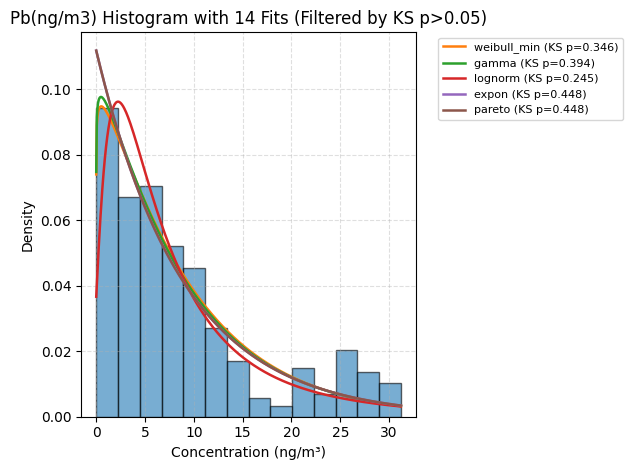

,dist,KS_p,AIC,BIC
10,expon,4.477785e-01,2524.505218,2532.462990
12,pareto,4.477779e-01,2526.505240,2538.441897
8,gamma,3.941065e-01,2525.882778,2537.819435
7,weibull_min,3.456535e-01,2525.124950,2537.061608
9,lognorm,2.450819e-01,2560.860484,2572.797141
5,gumbel_r,8.873077e-03,2638.526045,2646.483816
4,beta,2.950794e-04,2490.598318,2506.513861
13,beta,2.950794e-04,2490.598318,2506.513861
0,norm,4.143697e-07,2777.205176,2785.162948
3,logistic,8.083298e-08,2760.679690,2768.637462


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math, warnings
warnings.filterwarnings("ignore")

# Pb 데이터 불러오기
x = pd.to_numeric(df["Pb(ng/m3)"], errors="coerce").dropna().values

# 후보 14개 분포 (scipy 이름 그대로 사용 → 영어 표시)
DIST_LIST = [
    "norm","t","triang","logistic","beta",
    "gumbel_r","gumbel_l","weibull_min","gamma","lognorm",
    "expon","uniform","pareto","beta"  # BetaPERT 근사로 beta 재사용
]

def count_params(dist_name, params):
    try:
        d = getattr(stats, dist_name)
        return d.numargs + 2
    except:
        return len(params)

def loglikelihood(dist_name, params, x):
    d = getattr(stats, dist_name)
    pdf = d.pdf(x, *params)
    eps = 1e-300
    return np.sum(np.log(np.clip(pdf, eps, None)))

results = []

# 히스토그램 기본 (확률밀도)
counts, bins, _ = plt.hist(x, bins="auto", density=True, edgecolor="black", alpha=0.6)
N = len(x)
xgrid = np.linspace(bins[0], bins[-1], 500)

# 분포별 피팅 + PDF 곡선
for scipy_name in DIST_LIST:
    try:
        d = getattr(stats, scipy_name)
        params = d.fit(x)
        # KS 검정
        D, pks = stats.kstest(x, scipy_name, args=params)
        # AIC/BIC
        ll = loglikelihood(scipy_name, params, x)
        k = count_params(scipy_name, params)
        aic = 2*k - 2*ll
        bic = math.log(N)*k - 2*ll
        # PDF 곡선 (KS p>0.05인 분포만 표시)
        if pks > 0.05:
            pdf = d.pdf(xgrid, *params)
            plt.plot(xgrid, pdf, lw=1.8, label=f"{scipy_name} (KS p={pks:.3f})")

        results.append({
            "dist": scipy_name, "params": params, "KS_p": pks,
            "AIC": aic, "BIC": bic
        })
    except Exception as e:
        results.append({
            "dist": scipy_name, "KS_p": np.nan,
            "AIC": np.nan, "BIC": np.nan, "error": str(e)
        })

# 그래프 설정
plt.title("Pb(ng/m3) Histogram with 14 Fits (Filtered by KS p>0.05)")
plt.xlabel("Concentration (ng/m³)")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 결과표 정리
df_res = pd.DataFrame(results)
df_res = df_res.dropna(subset=["KS_p"]).sort_values("KS_p", ascending=False)
display(df_res[["dist","KS_p","AIC","BIC"]])